In [124]:
%pip install torchdiffeq

Note: you may need to restart the kernel to use updated packages.


In [125]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian

from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj
torch.version.__version__

'2.1.2'

Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equations get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [126]:
class constant_force:
    
    def __init__(self, m, g):
        self.m = m
        self.g = g
        self.dof = 2
        self.toy_position_example = np.array([0.3])
        self.toy_velocity_example = np.array([1.0])
        self.toy_time_dataset = np.arange(0, 4, 0.001)
        self.position_bounds = (0,1)
        self.velocity_bounds = (-2,2)
        
    def set_g(g):
        self.g = g
    
    def kinetic(self, x):
        return 0.5 * self.m * x[1]**2
    
    def potential(self, x):
        return self.m * self.g * x[0]
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T - V

    def energy(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        return -self.g
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        plt.plot(t, path[:, 0], label = labelstr)
        
    def plot_lagrangian(self, t, path, lagrangian, labelstr = ""):
        plt.plot(t, [lagrangian(l) for l in path], label = labelstr)



In [ ]:
class harmonic_oscillator_spring_1d:
    
    def __init__(self, m, k):
        self.m = m
        self.k = k
        self.dof = 2
        self.toy_position_example = np.array([0.3])
        self.toy_velocity_example = np.array([1.0])
        self.toy_time_dataset = np.arange(0, 4, 0.001)
        self.position_bounds = (-1,1)
        self.velocity_bounds = (-2,2)

    def kinetic(self, x):
        return 0.5 * self.m * x[1]**2
    
    def potential(self, x):
        return 0.5 * self.k * x[0]**2
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T - V
    
    def energy(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        return -self.k * q / self.m
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        plt.plot(t, path[:, 0], label = labelstr)

    def plot_lagrangian(self, t, path, lagrangian, labelstr = ""):
        plt.plot(t, [lagrangian(l) for l in path], label = labelstr)


In [127]:
class spring_pendulum:
    
    def __init__(self, k, g):
        self.k = k
        self.g = g
        self.dof = 4
        self.toy_position_example = np.array([1.1, 0.5])
        self.toy_velocity_example = np.array([0.0, 0.0])
        self.toy_time_dataset = np.arange(0, 5, 0.005)
        self.position_bounds = (0,1)
        self.velocity_bounds = (-2,2)
        
    def kinetic(self, q, qt):
        return 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    
    def potential(self, q, qt, cos):
        return self.g*q[0]*(1-cos(q[1])) + self.k*(q[0] - 1)**2
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        q, qt = torch.split(x, 2)
        T = self.kinetic(q, qt)
        V = self.potential(q, qt, torch.cos)
        return T - V

    def energy(self, x):
        try:
            q, qt = torch.split(x, self.dof//2)
            cos = torch.cos
        except: 
            q, qt = np.split(x, self.dof//2)
            cos = np.cos
        T = self.kinetic(q, qt)
        V = self.potential(q, qt, cos)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        '''
        q is [r, theta]
        qdot is [rdot, thetadot]

        returns q double dot.
        '''
        qdtt = np.zeros_like(q)
        
        qdtt[:, 0] = q[:, 0]*qdot[:, 1]**2 - self.g*(1-np.cos(q[:, 1])) - 2*self.k*(q[:, 0]-1) 
        qdtt[:, 1] = (-self.g*np.sin(q[:, 1]) -2*qdot[:, 0]*qdot[:, 1])/q[:, 0]

        return qdtt  
    
    def polar_to_cartesian(self, ql):
        '''
        Polar coords to xy
        '''
        try: 
            xy = np.zeros_like(ql)
            sin = np.sin
            cos = np.cos
        except: 
            xy = torch.zeros_like(ql)
            sin = torch.sin
            cos = torch.cos

        xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
        xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
        return xy
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        xy = self.polar_to_cartesian(path)
        plt.plot(xy[:, 0], xy[:, 1], label = labelstr)
    

In [128]:
trial = 0

if (trial == 0):
    particle = constant_force(1, 1)
    
elif (trial == 1):
    particle = harmonic_oscillator_spring_1d(1,1)
    
elif (trial == 2):
    particle = spring_pendulum(10,10)

In [129]:
def get_qdotdot(total_state, analytical_solution):
    '''
    total_state is a tensor of generalised coords and velocities,
    returns q double dot.
    '''
    dims = total_state.shape[1]
    if dims%2 != 0:
        raise ValueError("The input total_state must have an even number of columns.")
    return analytical_solution(total_state[:, :dims//2], total_state[:, dims//2:])


# Returns q_dot and q_dotdot 

#Want to make these functions as general as possible. so that they can be used for any system.

def analytically_differentiated_state(x, t, analytical_solution):
    d = np.zeros_like(x)
    
    #Remove 2's, make it general
    n_cols = x.shape[1]
    if n_cols % 2 != 0:
        raise ValueError("The input x must have an even number of columns.")
    d[:, :n_cols//2] = x[:, n_cols//2:]
    d[:, n_cols//2:] = get_qdotdot(x, analytical_solution)
    return d


# This takes only 4 numbers: the starting position and velocity. 
# f_analytic function returns q_dot and q_dotdot for 1 dimensional inputs.

# Returns:
# An array containing the value of y for each desired time in t, with the initial value y0 in the first row.


def ode_solve_analytic(q0, qt0, t, analytical_solution):

    x0 = np.append(q0, qt0)

    def f_analytic(x, t):
        d = np.zeros_like(x)
        n_cols = x.shape[0]
        d[:n_cols//2] = x[n_cols//2:]
        d[n_cols//2:] = np.squeeze(get_qdotdot(np.expand_dims(x, axis=0), analytical_solution))
        # print(x, d)
        return d
    
    return odeint(f_analytic, x0, t, rtol=1e-10, atol=1e-10)
    



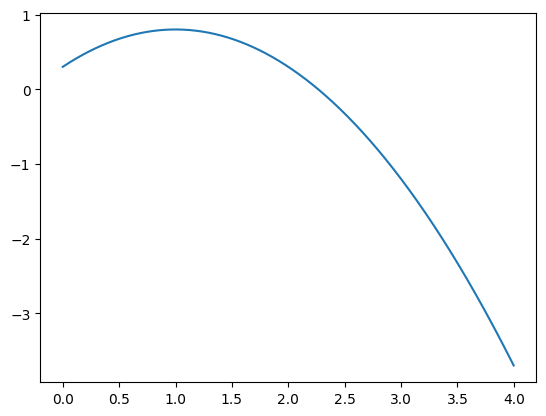

In [130]:
t = particle.toy_time_dataset
q0 = particle.toy_position_example
qt0 = particle.toy_velocity_example

path = ode_solve_analytic(q0, qt0, t, particle.solve_acceleration)

particle.plot_solved_dynamics(t, path)

We can also solve using pytorch to autodiff the lagrangian, an use the following version of the EL equations (after Cranmer et al.), with $q=(r, \theta)$:

$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]$





In [131]:
# Gets the q_dot, q_dotdot by differentiating a function "lagrangian" wrt E-L equations.

def get_diff_state_lagr(lagrangian, t, x):
    n = x.shape[0]//2
    xv = torch.autograd.Variable(x, requires_grad=True)
    tq, tqt = torch.split(xv, n, dim=0)
    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
    B = jacobian(lagrangian, xv, create_graph=True)[:n]
    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]
    tqtt = A @ (B - C @ tqt)
    xt = torch.cat([tqt, tqtt])

    return xt


# This takes the starting coordinates and f fills the first argument of get_diff_state_lagr with "lagrangian",
# so that this can directly go into tor_odeint function, which is similar to the previous one.
def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_diff_state_lagr, lagrangian)
    return tor_odeint(f, x0, t)

In [132]:
tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)])
tt = torch.tensor(t)
tpath = torch_solve_ode(tx0, tt, particle.lagrangian)


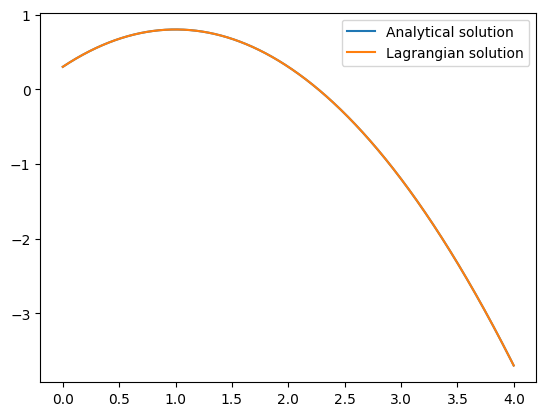

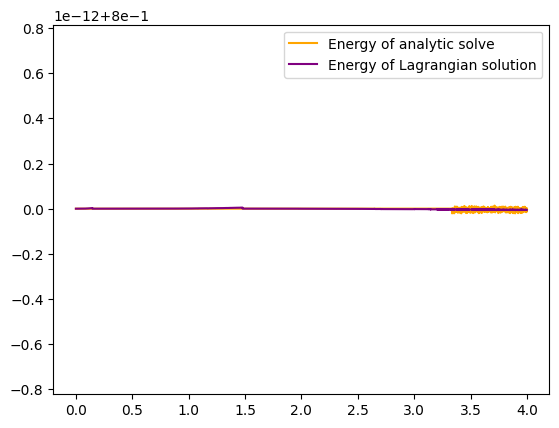

In [133]:
particle.plot_solved_dynamics(t, path, "Analytical solution")
particle.plot_solved_dynamics(t, tpath.detach(), "Lagrangian solution")
plt.legend()
plt.show()

En = [particle.energy(x) for x in path]
Ent = [particle.energy(x) for x in tpath.detach()]

plt.plot(t, En, color='orange', label='Energy of analytic solve')
plt.plot(t, Ent, color='purple', label= 'Energy of Lagrangian solution')
plt.legend()
plt.show()

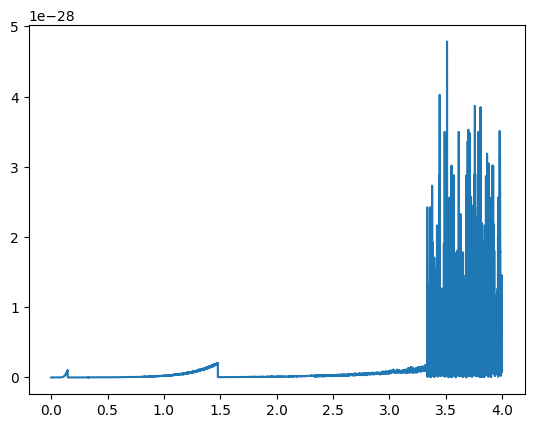

In [134]:
# Mean square difference between analytical straight solution and analytical Lagrangian solution.

plt.plot(t, np.sum((tpath.detach().numpy() - path)**2, axis=1))

In [135]:
def random_initialize(start=0, end=10, dim=2, distribution='uniform'):
    if distribution == 'uniform':
        positions = np.random.uniform(start, end, size=(dim,))
        return positions
    if distribution == 'gaussian':
        mean = (start + end) / 2  # Mean of the Gaussian distribution
        std_dev = (end - start) / (2 * np.sqrt(3))  # Standard deviation of the Gaussian distribution
        positions = np.random.normal(mean, std_dev, size=(dim,))
        # Clip values to ensure they fall within the specified range
        positions = np.clip(positions, start, end)
        return positions
    else:
        raise ValueError("Invalid distribution type. Please choose 'uniform' or 'gaussian'.")

In [142]:
def random_initialize(start, end, dim, n, seed=None):
    if seed == None:
        return torch.rand((n, dim))*(end-start) + start
    else:
        gen = torch.Generator()
        gen.manual_seed(seed)
        return torch.rand((n, dim), generator=gen)*(end - start) + start


def create_training_data(n, dimension, position_tuple, velocity_tuple, seed):
    # Make a torch tensor with n random starting positions and velocities using uniform distribution:
    # Merge them into a single tensor.
    state = torch.cat([random_initialize(*position_tuple, dimension, n, seed), random_initialize(*velocity_tuple, dimension, n, seed)], dim=1)
    diff_state = torch.tensor(analytically_differentiated_state(state, 0, particle.solve_acceleration)).float()
    return [state, diff_state]


In [143]:
def create_test_data(number_of_batches, batch_len, time_step, dimension, position_tuple, velocity_tuple, seed):
    state_list = []
    diff_state_list = []
    t_test = torch.arange(0, time_step*batch_len, time_step)
    for i in range(number_of_batches):
        gen = torch.Generator()
        gen.manual_seed(seed+i)
        start_pos_vector = torch.rand(dimension, generator = gen)*(position_tuple[1] - position_tuple[0]) + position_tuple[0]
        start_vel_vector = torch.rand(dimension, generator = gen)*(velocity_tuple[1] - velocity_tuple[0]) + velocity_tuple[0]
        q_qdot = torch.tensor(ode_solve_analytic(start_pos_vector, start_vel_vector, t_test, particle.solve_acceleration)).float()
        qdot_qdotdot = torch.tensor(analytically_differentiated_state(q_qdot, t_test, particle.solve_acceleration)).float()
        state_list.append(q_qdot)
        diff_state_list.append(qdot_qdotdot)
    return [state_list, diff_state_list, t_test]


In [144]:
total_data_points = 4000
position_start_end = particle.position_bounds
velocity_start_end = particle.velocity_bounds
train_seed = 86 
training_data = create_training_data(total_data_points, particle.dof//2, 
                                        position_start_end, velocity_start_end, 
                                        seed = train_seed)

In [145]:
batch_number = 4
test_batch_len = 500
time_step = 0.001
test_seed = 96
testing_data = create_test_data(batch_number, test_batch_len, 
                                    time_step, particle.dof//2, 
                                    position_start_end, velocity_start_end, 
                                    seed = test_seed)

In [146]:
# "Normalize", otherwise nn weights and losses explode badly.

# In a physical system, normalization is just a unit conversion. We are just scaling our coordinates.

# We need the train and test data together to determine how much we are going to scale.

def normalize_data(training_data, testing_data):
    maximum = torch.max(torch.abs(training_data[0]))
    maximum = max(maximum, torch.max(torch.abs(training_data[1])))
    for i in range(len(testing_data[0])):
        maximum = max(maximum, torch.max(torch.abs(testing_data[0][i])))
        maximum = max(maximum, torch.max(torch.abs(testing_data[1][i])))

    training_data[0] = training_data[0]/maximum
    training_data[1] = training_data[1]/maximum

    for i in range(len(testing_data[0])):
        testing_data[0][i] = testing_data[0][i]/maximum
        testing_data[1][i] = testing_data[1][i]/maximum
    
    return maximum, training_data, testing_data

In [148]:
scale_factor, training_data, testing_data = normalize_data(training_data, testing_data)

print("Scale factor:", scale_factor)

q_qdot_train, qdot_qdotdot_train = training_data

print("State",q_qdot_train)
print("Differentiated state", qdot_qdotdot_train)


q_qdot_test_list, qdot_qdotdot_test_list, t_test = testing_data

print("Test state 0:",q_qdot_test_list[0][0:10])
print("Test differentiated state 0:",qdot_qdotdot_test_list[0][0:10])

Scale factor: tensor(1.)
State tensor([[ 0.4338,  0.7349],
        [ 0.1131, -0.5478],
        [ 0.0079, -0.9686],
        ...,
        [ 0.1741, -0.3037],
        [ 0.4810,  0.9238],
        [ 0.0236, -0.9060]])
Differentiated state tensor([[ 0.7349, -0.5001],
        [-0.5478, -0.5001],
        [-0.9686, -0.5001],
        ...,
        [-0.3037, -0.5001],
        [ 0.9238, -0.5001],
        [-0.9060, -0.5001]])
Test state 0: tensor([[0.4800, 0.3161],
        [0.4803, 0.3156],
        [0.4807, 0.3151],
        [0.4810, 0.3146],
        [0.4813, 0.3141],
        [0.4816, 0.3136],
        [0.4819, 0.3131],
        [0.4822, 0.3126],
        [0.4825, 0.3121],
        [0.4829, 0.3116]])
Test differentiated state 0: tensor([[ 0.3161, -0.5001],
        [ 0.3156, -0.5001],
        [ 0.3151, -0.5001],
        [ 0.3146, -0.5001],
        [ 0.3141, -0.5001],
        [ 0.3136, -0.5001],
        [ 0.3131, -0.5001],
        [ 0.3126, -0.5001],
        [ 0.3121, -0.5001],
        [ 0.3116, -0.5001]])

In [ ]:
# test_state , test_diff_state = create_test_data(4,500,0.001,1,(0,1),(-2,2), seed = 96)

# print(len(test_state), test_state[0].shape)
# print(len(test_diff_state), test_diff_state[0].shape)

In [ ]:
# Dataset involving only one starting configuration:
# total_data_points = 4000
# t_start = 0 
# t_end = 4
# t_total = torch.tensor(np.linspace(t_start, t_end, total_data_points)).float()
# tstep = t_total[1].item() 
# 
# train_indices = torch.randperm(total_data_points)
# t_train = t_total[train_indices]
# 
# starting_positions = particle.toy_position_example
# starting_velocities = particle.toy_velocity_example
# 
# unnormalized_q_qdot_total = torch.tensor(ode_solve_analytic(starting_positions, starting_velocities, t_total, particle.solve_acceleration)).float()
# 
# #max_value = torch.max(torch.abs(q_qdot_total))
# max_value = 1
# 
# # Normalize the tensor
# q_qdot_total = unnormalized_q_qdot_total / max_value
# 
# print("State",q_qdot_total)
# 
# q_qdot_train = q_qdot_total[train_indices]
# q_qdot_test = q_qdot_total
# 
# qdot_qdotdot_total = torch.tensor(analytically_differentiated_state(unnormalized_q_qdot_total, t_total, particle.solve_acceleration)).float()
# 
# print("Differentiated state")
# print(qdot_qdotdot_total)
# 
# qdot_qdotdot_train = qdot_qdotdot_total[train_indices]

In [149]:
class LNN(nn.Module):
    def __init__(self, input_size):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def lagrangian(self, x):
        
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        
        return x 

    def forward(self, x):
        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        #xv_tup is tuple of "states" in various time frames.
        tqt = xv[:, n:]

        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))
        
        #Why tuple?

        #print("A:", A)
        
        multi = lambda Ai, Bi, tqti, n:  torch.pinverse(Ai[n:, n:]) @ (Bi[:n, 0] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        xt.retain_grad()
        return xt

    def t_forward(self, t, x):
        return self.forward(x)
    
    def plot_lagrangian(self, x):
        return self.lagrangian(torch.Tensor(x)).detach()

def loss(pred, targ):
    return torch.mean(torch.abs(pred - targ))
 

In [150]:
def nn_solve_ode(model, x0, t):
    x0 = x0.detach().numpy()
    def f(x, t):
        x_tor = torch.tensor(np.expand_dims(x, 0), requires_grad=True).float()
        return np.squeeze(model(x_tor).detach().numpy(), axis=0)
    return odeint(f, x0, t) 

In [151]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

eps = 100
N = 1500 
batch_size = 32 

model = LNN(particle.dof)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min')
loss_list = []
for e in range(eps):
    running_loss = 0.
    for i in range(1, N // batch_size):
        optimizer.zero_grad()
        xi = q_qdot_train[(i-1)*batch_size:i*batch_size]
        qdot_qdotdot_pred = model(xi)

        loss_val = loss(qdot_qdotdot_pred, qdot_qdotdot_train[i])
        loss_val.backward()

        optimizer.step()

        running_loss += loss_val.item()
    scheduler.step(running_loss)
    
    print('Epoch %d loss: %.10f' % (e + 1, running_loss/N))
    loss_list.append(running_loss/N)
        
        

Epoch 1 loss: 0.0138968120
Epoch 2 loss: 0.0112072931
Epoch 3 loss: 0.0108511591
Epoch 4 loss: 0.0106259202
Epoch 5 loss: 0.0107941080
Epoch 6 loss: 0.0105583832
Epoch 7 loss: 0.0106238585
Epoch 8 loss: 0.0104489717
Epoch 9 loss: 0.0104165915
Epoch 10 loss: 0.0105738614
Epoch 11 loss: 0.0106087784
Epoch 12 loss: 0.0104511822
Epoch 13 loss: 0.0103507886
Epoch 14 loss: 0.0104313253
Epoch 15 loss: 0.0104073849
Epoch 16 loss: 0.0104471121
Epoch 17 loss: 0.0107438009
Epoch 18 loss: 0.0104342898
Epoch 19 loss: 0.0104504066
Epoch 20 loss: 0.0103333615
Epoch 21 loss: 0.0103087325
Epoch 22 loss: 0.0103897446
Epoch 23 loss: 0.0104136452
Epoch 24 loss: 0.0104297577
Epoch 25 loss: 0.0103663631
Epoch 26 loss: 0.0103738014
Epoch 27 loss: 0.0104806412
Epoch 28 loss: 0.0103817468
Epoch 29 loss: 0.0103280903
Epoch 30 loss: 0.0104605004
Epoch 31 loss: 0.0103493384
Epoch 32 loss: 0.0103209670
Epoch 33 loss: 0.0102234560
Epoch 34 loss: 0.0102121002
Epoch 35 loss: 0.0102110846
Epoch 36 loss: 0.0102124237
E

In [152]:
torch.save(model, '/kaggle/working/model_may6_0243.pt')

In [ ]:
#model = torch.load('/kaggle/input/first_model_lnn/pytorch/first/1/model.pt')
#model.eval()

In [153]:

#t_test should be either decreasing or increasing!!!

#If ODE does not return any errors or warning, then it's probably ok!!
nn_test_list = []

for test_data in q_qdot_test_list:
    nn_test_list.append(nn_solve_ode(model, test_data[0], t_test))
    print("Solved one")


Solved one
Solved one
Solved one
Solved one


In [154]:
for i in range(100):
    print((nn_test_list[0][i], q_qdot_test_list[0][i]))

(array([0.48003227, 0.31610817]), tensor([0.4800, 0.3161]))
(array([0.4803481 , 0.31562739]), tensor([0.4803, 0.3156]))
(array([0.48066349, 0.31514667]), tensor([0.4807, 0.3151]))
(array([0.4809784, 0.314666 ]), tensor([0.4810, 0.3146]))
(array([0.48129282, 0.31418538]), tensor([0.4813, 0.3141]))
(array([0.48160677, 0.31370481]), tensor([0.4816, 0.3136]))
(array([0.48192023, 0.3132243 ]), tensor([0.4819, 0.3131]))
(array([0.48223322, 0.31274384]), tensor([0.4822, 0.3126]))
(array([0.48254572, 0.31226343]), tensor([0.4825, 0.3121]))
(array([0.48285774, 0.31178307]), tensor([0.4829, 0.3116]))
(array([0.48316929, 0.31130277]), tensor([0.4832, 0.3111]))
(array([0.48348035, 0.31082251]), tensor([0.4835, 0.3106]))
(array([0.48379093, 0.31034231]), tensor([0.4838, 0.3101]))
(array([0.48410104, 0.30986216]), tensor([0.4841, 0.3096]))
(array([0.48441066, 0.30938206]), tensor([0.4844, 0.3091]))
(array([0.4847198 , 0.30890201]), tensor([0.4847, 0.3086]))
(array([0.48502847, 0.30842202]), tensor([

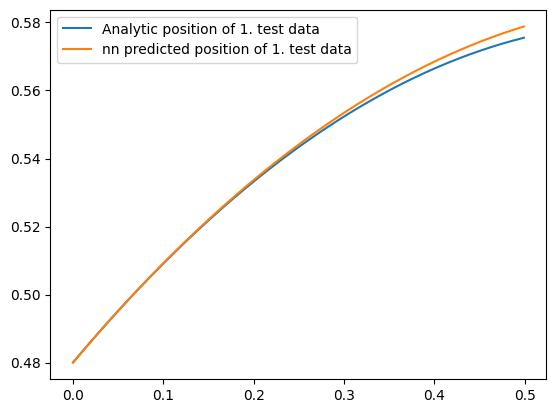

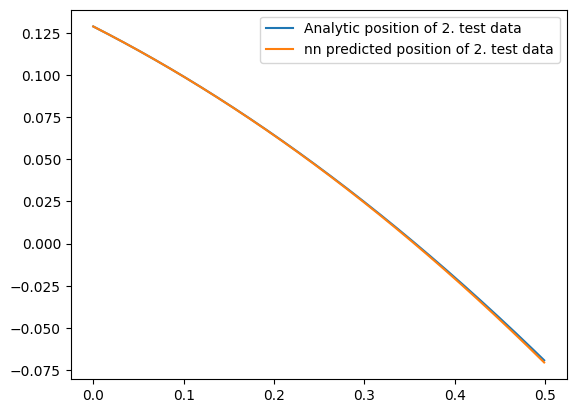

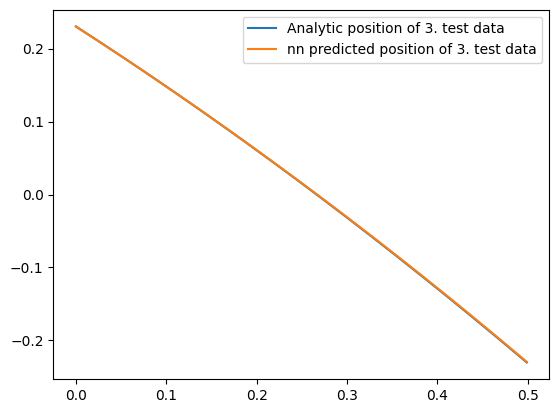

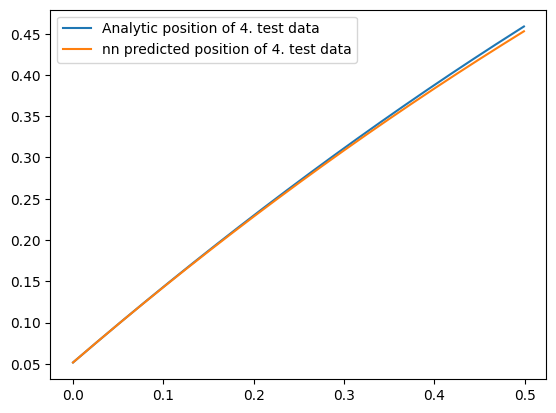

In [156]:
for i in range(len(nn_test_list)):
    particle.plot_solved_dynamics(t_test, q_qdot_test_list[i], labelstr = "Analytic position of {}. test data".format(i+1))
    particle.plot_solved_dynamics(t_test, nn_test_list[i], labelstr = "nn predicted position of {}. test data".format(i+1))
    plt.legend()
    plt.show()

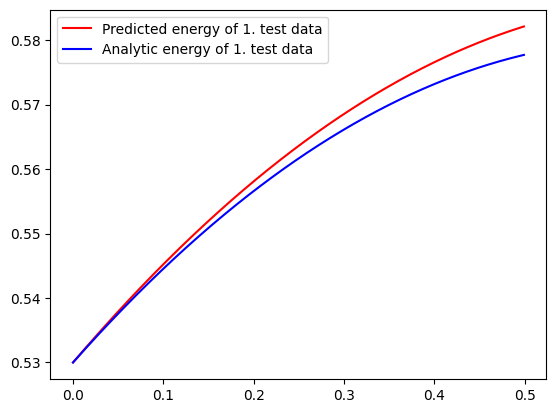

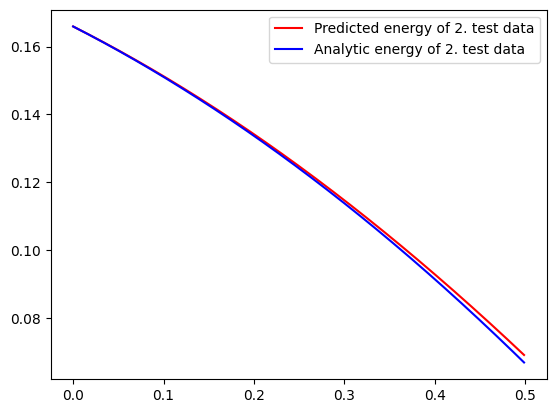

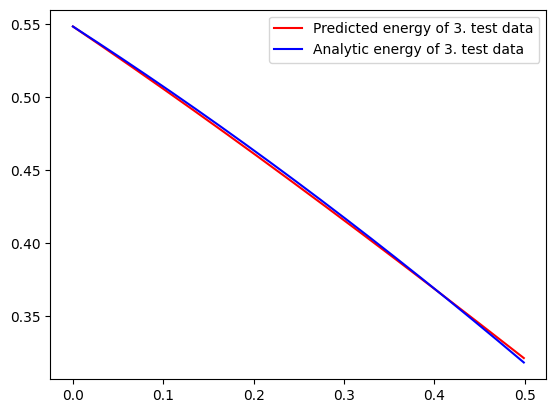

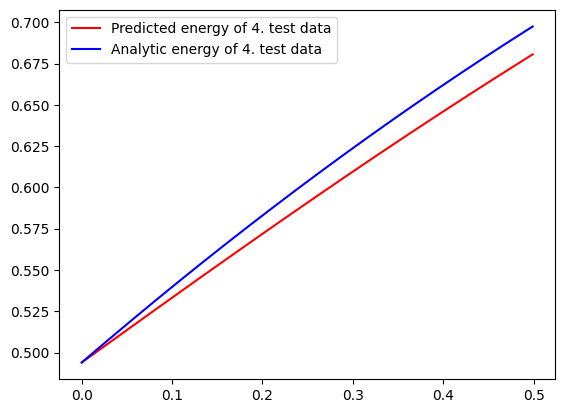

In [157]:
for i in range(len(nn_test_list)):
    E_test = [particle.energy(x) for x in q_qdot_test_list[i]]
    E_lnn = [particle.energy(x) for x in nn_test_list[i]]
    plt.plot(t_test, E_lnn, color='red', label='Predicted energy of {}. test data'.format(i+1))
    plt.plot(t_test, E_test, color='blue', label='Analytic energy of {}. test data'.format(i+1))
    plt.legend()
    plt.show()



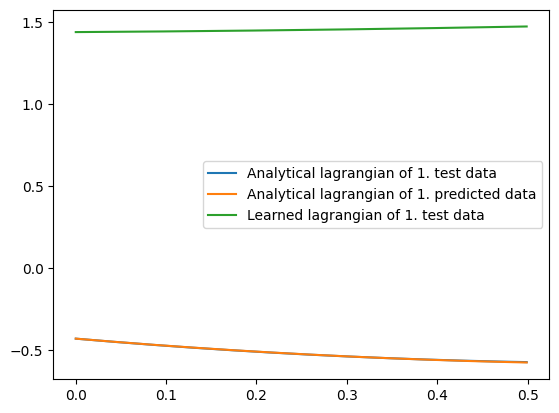

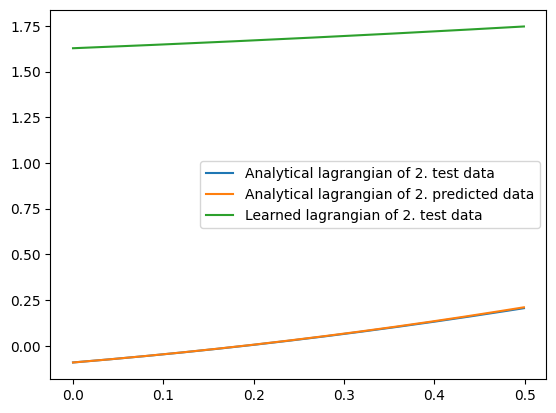

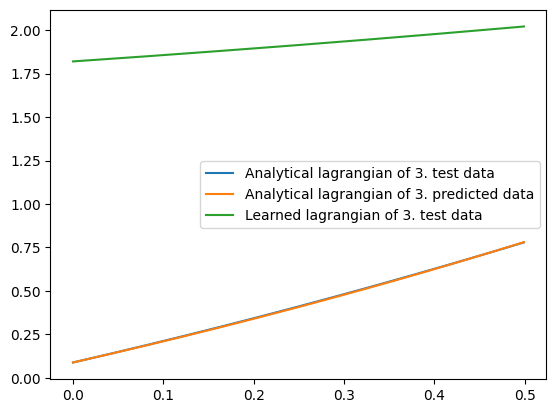

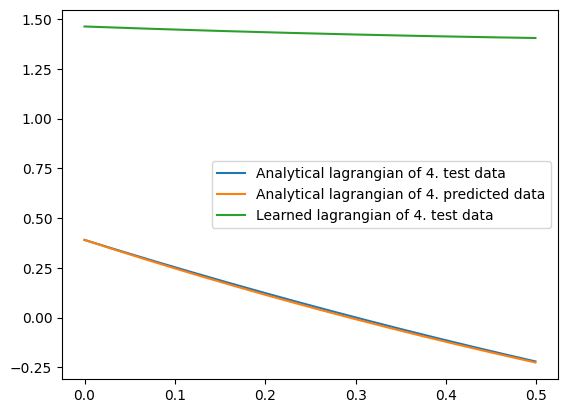

In [158]:
# Plotting lagrangians

# Future work: see whether the difference is close to a total derivative! Lagrangian is not unique.

for i in range(len(nn_test_list)):
    particle.plot_lagrangian(t_test, q_qdot_test_list[i], particle.lagrangian, 'Analytical lagrangian of {}. test data'.format(i+1))
    particle.plot_lagrangian(t_test, nn_test_list[i], particle.lagrangian, 'Analytical lagrangian of {}. predicted data'.format(i+1))
    particle.plot_lagrangian(t_test, q_qdot_test_list[i], model.plot_lagrangian, 'Learned lagrangian of {}. test data'.format(i+1))
    plt.legend()
    plt.show()